In [45]:
from colour import Color
import numpy as np
import gmaps.geojson_geometries
import requests
import gzip
import pandas as pd
import gmaps
import os
import gzip
from tqdm.notebook import trange, tqdm
from pathlib import Path

API_KEY = "<YOUR GMAP API KEY HERE>"

gmaps.configure(api_key= API_KEY)

In [59]:
def decompress_file(file, dest_file):
    with gzip.open(file, "rb") as c:
        with open(dest_file, 'wb') as f:
            f.write(c.read())
    

def download_geo_data(year, departement, local_filename):
    data_url = f"https://files.data.gouv.fr/geo-dvf/latest/csv/{year}/departements/{departement}.csv.gz"
    gz_file = f"{local_filename}.gz"
    with requests.get(data_url, stream=True) as r:
        r.raise_for_status()
        with open(gz_file, 'wb') as f:
            total_size_in_bytes = int(r.headers.get('content-length', 0))
            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            for chunk in r.iter_content(chunk_size=8192): 
                progress_bar.update(len(chunk))
                f.write(chunk)
            progress_bar.close()
            
    decompress_file(gz_file, local_filename)
    return local_filename

def download_if_missing(year, departement, folder = "data"):
    local_filename = f"{folder}/{year}/{departement}.csv"
    if os.path.exists(local_filename):
        return
    else:
        path = Path(f'{folder}/{year}/')
        path.mkdir(parents=True, exist_ok=True)
        download_geo_data(year, departement, local_filename)

In [60]:
years = [2017,2018,2019,2020,2021]
for y in years:
    download_if_missing(y, 75)

  0%|          | 0.00/1.90M [00:00<?, ?iB/s]

  0%|          | 0.00/1.88M [00:00<?, ?iB/s]

  0%|          | 0.00/1.94M [00:00<?, ?iB/s]

  0%|          | 0.00/1.58M [00:00<?, ?iB/s]

  0%|          | 0.00/2.12M [00:00<?, ?iB/s]

In [61]:
data = pd.concat([pd.read_csv(f"data/{y}/75.csv", sep=',', header=0) for y in years])

/var/folders/sh/28t_wkp94hbdxp8kt_kftzx00000gn/T/ipykernel_3112/2531298216.py:1: DtypeWarning: Columns (18,20,22,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  data = pd.concat([pd.read_csv(f"data/{y}/75.csv", sep=',', header=0) for y in years])
/var/folders/sh/28t_wkp94hbdxp8kt_kftzx00000gn/T/ipykernel_3112/2531298216.py:1: DtypeWarning: Columns (8,18,20,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  data = pd.concat([pd.read_csv(f"data/{y}/75.csv", sep=',', header=0) for y in years])
/var/folders/sh/28t_wkp94hbdxp8kt_kftzx00000gn/T/ipykernel_3112/2531298216.py:1: DtypeWarning: Columns (18,20,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  data = pd.concat([pd.read_csv(f"data/{y}/75.csv", sep=',', header=0) for y in years])
/var/folders/sh/28t_wkp94hbdxp8kt_kftzx00000gn/T/ipykernel_3112/2531298216.py:1: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or

In [62]:
import json
streets = {}
with open("voie.geojson", "r") as f:
    street_data = json.load(f)
for f in street_data["features"]:
    if "properties" in f and "c_voie" in f["properties"]:
        oid = f["properties"]["c_voie"]
        fan = oid[-4:]
        streets[fan]=f

Exception ignored in: <function tqdm.__del__ at 0x1273fc160>
Traceback (most recent call last):
  File "/Users/charlesroussel/miniforge3/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/Users/charlesroussel/miniforge3/lib/python3.9/site-packages/tqdm/notebook.py", line 285, in close
    if self.total and self.n < self.total:
TypeError: '<' not supported between instances of 'int' and 'str'


In [63]:
def group_id(df):
    agg = df.groupby("id_mutation").agg({
        "code_commune": lambda x: x.iloc[0],
        "nom_commune": lambda x: x.iloc[0],
        "valeur_fonciere":"max", 
        "lot1_surface_carrez":"sum",
        "lot2_surface_carrez":"sum", 
        "lot3_surface_carrez":"sum", 
        "lot4_surface_carrez":"sum", 
        "lot5_surface_carrez":"sum", 
        "surface_reelle_bati":"sum",
        'latitude':"mean", 
        'longitude':"mean",
        "type_local": lambda x: list(i[1] for i in x.items()),
        "adresse_nom_voie": lambda x: x.iloc[0],
        "adresse_code_voie": lambda x: x.iloc[0],
    })
    return agg

def filter_data(df, city_code):
    proj = df[df["code_commune"].isin(city_code)]
    proj = proj[proj["nature_culture"].isnull()]
    proj = proj[proj["latitude"].notnull()]
    proj = proj[proj["longitude"].notnull()]
    return proj

def enrich_data_surface(df):
    df = df.copy()
    surface = df.fillna(0)["lot1_surface_carrez"]
    for col in ["lot2_surface_carrez", "lot3_surface_carrez", "lot4_surface_carrez", "lot5_surface_carrez"]:
        surface += df.fillna(0)[col]
        
    df["surface_carrez"] = surface
    df["surface"] = np.where(df["surface_carrez"] != 0, df["surface_carrez"], df["surface_reelle_bati"])
    return df

def enrich_price_m2(df):
    df = df.copy()
    df["price_m2"] = df["valeur_fonciere"] / df["surface"]
    return df

In [64]:
paris_commune = data[data["code_departement"]==75]["code_commune"].unique()
df = filter_data(data, city_code=paris_commune)
df = group_id(df)
df = enrich_data_surface(df)
df = df[df["surface"] > 0]
df = df[df["type_local"].apply(lambda x: 'Appartement' in x)]
df = enrich_price_m2(df)
df = df[df["price_m2"] < 70000]

In [65]:
bin_count = 10
ruedf = df.groupby(["nom_commune", "adresse_nom_voie","adresse_code_voie"]).agg(count=("price_m2", "count"), price_m2 = ("price_m2", "mean"))
filtered = ruedf[ruedf["count"] > 2]
filtered['bin'] = pd.cut(filtered['price_m2'], bins = bin_count, precision=0, labels=False)
filtered['qbin'] = pd.qcut(filtered['price_m2'], q = bin_count, precision=0, labels=False)
for i in filtered["price_m2"].sort_values().iteritems():
    print(i)

/var/folders/sh/28t_wkp94hbdxp8kt_kftzx00000gn/T/ipykernel_3112/4062742920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['bin'] = pd.cut(filtered['price_m2'], bins = bin_count, precision=0, labels=False)
/var/folders/sh/28t_wkp94hbdxp8kt_kftzx00000gn/T/ipykernel_3112/4062742920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['qbin'] = pd.qcut(filtered['price_m2'], q = bin_count, precision=0, labels=False)


(('Paris 14e Arrondissement', 'IMP CELS', '1637'), 62.43589743589744)
(('Paris 15e Arrondissement', 'RUE DU CDT LEANDRI', '2233'), 3609.2222985895255)
(('Paris 19e Arrondissement', 'RUE DES SEPT ARPENTS', '8924'), 3674.6388901332234)
(('Paris 16e Arrondissement', 'RUE GEORGES VILLE', '4153'), 4048.6947209121777)
(('Paris 3e Arrondissement', 'RUE PAPIN', '7040'), 4664.581452548814)
(('Paris 19e Arrondissement', 'RUE DE LA GRENADE', '4308'), 4676.5070744748455)
(('Paris 12e Arrondissement', 'RUE PLEYEL', '7538'), 4915.15671507296)
(('Paris 18e Arrondissement', 'RUE DU PRE', '7788'), 4965.131545261034)
(('Paris 20e Arrondissement', 'SQ VITRUVE', '9889'), 5068.630666512077)
(('Paris 2e Arrondissement', 'RUE NOTRE DAME DES VICTOIRES', 6840.0), 5182.069056251515)
(('Paris 18e Arrondissement', 'RUE PIERRE L ERMITE', '7449'), 5193.005680142268)
(('Paris 19e Arrondissement', 'RUE DE LA MARSEILLAISE', '6120'), 5199.702063008202)
(('Paris 18e Arrondissement', 'PAS DU ROI D ALGER', '8313'), 5210.4

(('Paris 15e Arrondissement', 'VLA DE GRENELLE', '4315'), 10452.682519689812)
(('Paris 11e Arrondissement', 'RUE DE CRUSSOL', '2475'), 10453.237928712128)
(('Paris 15e Arrondissement', 'PL DU COMMERCE', '2244'), 10453.364093604865)
(('Paris 16e Arrondissement', 'RUE CHARLES DICKENS', '1823'), 10457.294796237193)
(('Paris 16e Arrondissement', 'IMP DES CARRIERES', '1574'), 10460.13468598781)
(('Paris 5e Arrondissement', 'RUE GAY-LUSSAC', '3998'), 10460.477710797164)
(('Paris 16e Arrondissement', 'RUE CORTAMBERT', '2347'), 10460.562464666964)
(('Paris 16e Arrondissement', 'VLA PATRICE BOUDARD', '7105'), 10464.762250514492)
(('Paris 9e Arrondissement', 'RUE VICTOR MASSE', '9775'), 10466.513452661999)
(('Paris 4e Arrondissement', 'RUE JEAN BEAUSIRE', '4861'), 10472.92700554868)
(('Paris 3e Arrondissement', 'RUE CHAPON', '1771'), 10474.61031139456)
(('Paris 7e Arrondissement', 'RUE JEAN NICOT', '4935'), 10474.932083280893)
(('Paris 1er Arrondissement', 'RUE ETIENNE MARCEL', '3392'), 10479.50

<AxesSubplot:>

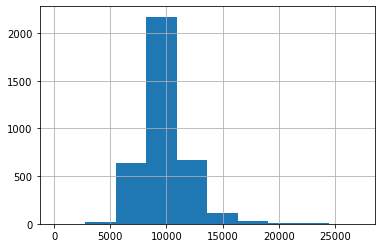

In [66]:
filtered["price_m2"].hist(bins=bin_count)

In [ ]:
red = Color("red")
blue = Color("blue")
color_list = [i.hex_l for i in blue.range_to(red, bin_count)]
fig = gmaps.figure(center=(48.85756,2.34280), zoom_level=13, layout={'height': '800px'})
for i in range(0, bin_count):
    df_bin = filtered[filtered["qbin"] == i]
    features = []
    for (key, value) in df_bin.iterrows(): 
        code = key[2]
        if code in streets:
            geo = streets[code]
            features.append(geo)
    if len(features) > 0:
        collection = {"type":"FeatureCollection","features":features}
        color = color_list[i]
        layer = gmaps.geojson_layer(collection, fill_color=color, stroke_color=color, fill_opacity=0.2, stroke_weight=3)
        fig.add_layer(layer)

In [ ]:
fig